# Statement

A companhia de seguros Proteja Seu Amanhã quer resolver algumas tarefas com a ajuda de aprendizado de máquina e você precisa avaliar a possibilidade de fazê-lo.

- Tarefa 1: Encontrar clientes semelhantes a um determinado cliente. Isso vai ajudar os agentes da empresa com tarefas de marketing.
- Tarefa 2: Predizer se um novo cliente provavelmente receberá um pagamento de seguro. Um modelo de predição pode ser melhor do que um modelo dummy?
- Tarefa 3: Predizer o número de pagamentos de seguro que um novo cliente provavelmente receberá usando um modelo de regressão linear.
- Tarefa 4: Proteger os dados pessoais dos clientes sem estragar o modelo da tarefa anterior. É necessário desenvolver um algoritmo de transformação de dados que tornaria difícil recuperar informações pessoais se os dados caíssem nas mãos erradas. Isso é chamado de mascaramento de dados ou ofuscação de dados. Mas os dados devem ser protegidos de forma que a qualidade dos modelos de aprendizado de máquina não piore. Você não precisa escolher o melhor modelo, só prove que o algoritmo funciona corretamente.

# Pré-processamento de dados & Exploração

## Inicialização

In [4]:
pip install scikit-learn --upgrade --user

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 56.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


O upgrade da scikit-learn não estava funcionando por falta de permissões. Adicionei o comando --user para que desse certo. Ai sim, o upgrade funcionou.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

from IPython.display import display

## Carregar Dados

Carregue os dados e faça uma verificação básica de que estão livres de problemas óbvios.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renomeamos as colunas para tornar o código mais consistente com seu estilo.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4797,1,29.0,36600.0,2,0
2360,1,40.0,43800.0,0,0
1719,0,38.0,37000.0,2,0
4116,0,35.0,41600.0,4,0
1874,1,41.0,40900.0,0,0
984,1,28.0,62400.0,1,0
785,0,20.0,35800.0,0,0
3520,1,22.0,60000.0,0,0
17,1,41.0,33200.0,2,0
8,1,36.0,49700.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# podemos querer corrigir o tipo de idade (de float para int), embora isso não seja crítico

# escreva sua conversão aqui se você escolher:
df['age'] = df['age'].astype(int)
print(df['age'])

0       41
1       46
2       29
3       21
4       28
        ..
4995    28
4996    34
4997    20
4998    22
4999    28
Name: age, Length: 5000, dtype: int64


In [7]:
# verifique se a conversão foi bem-sucedida
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# agora dê uma olhada nas estatísticas descritivas dos dados.
# Parece que está tudo bem?

In [9]:
print(df.describe())

            gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000  


Pelos valores indicados no método describe, está tudo bem. Nenhuma coluna apresenta valores médios, máximos ou mínimos fora do esperado. Os desvios padrões e quartis também parecem fazer sentido com o que cada coluna busca representar. Nossa única questão é um desbalanceamento de dados na coluna 'insurance_benefits'. Esse é um desbalanceamentoi normal, visto que são poucos os clientes que getralmente recebem retorno de seguro, mas essa característica pode atrapalhar alguns modelos. Não faremos nada por ora, mas isso é algo para mantermos em mente.

## AED

Vamos verificar rapidamente se existem determinados grupos de clientes observando o gráfico de pares.

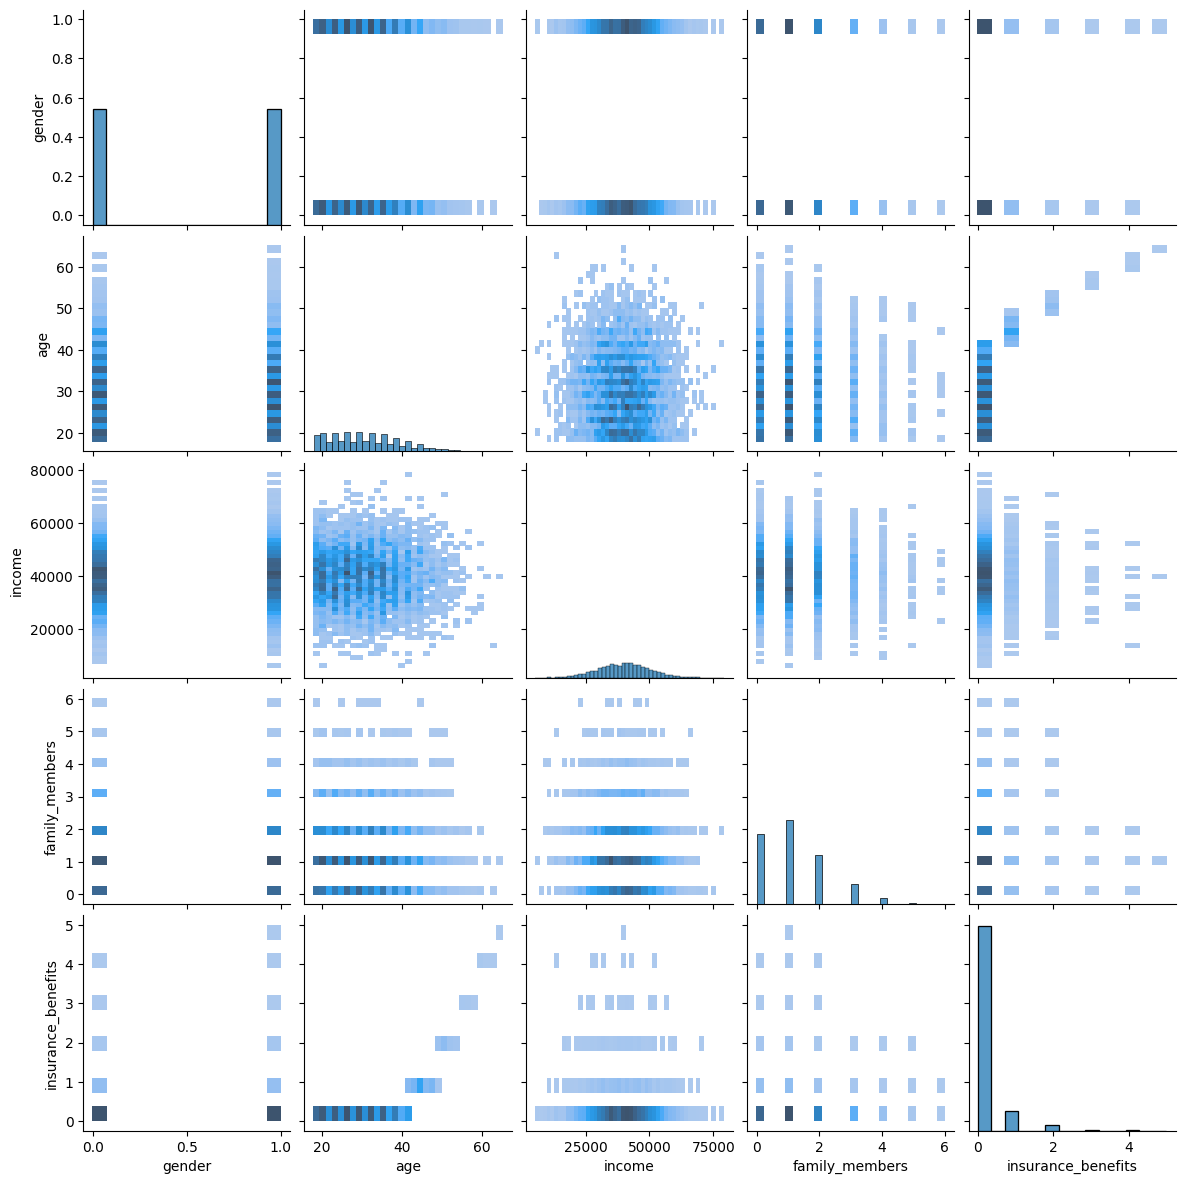

In [10]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, é um pouco difícil identificar grupos óbvios (clusters), pois é difícil combinar várias variáveis simultaneamente (para analisar distribuições multivariadas). É aí que Álgebra Linear e Aprendizado de Máquina podem ser bastante úteis.

# Tarefa 1. Clientes Similares

Na linguagem de AM, é necessário desenvolver um procedimento que retorne k vizinhos mais próximos (objetos) para um determinado objeto com base na distância entre os objetos.
Você pode querer rever as seguintes lições (capítulo -> lição)- Distância Entre Vetores -> Distância Euclidiana
- Distância Entre Vetores -> Distância de Manhattan

Para resolver a tarefa, podemos tentar diferentes métricas de distância.

Escreva uma função que retorne k vizinhos mais próximos para um n-ésimo objeto com base em uma métrica de distância especificada. O número de pagamentos de seguro recebidos não deve ser levado em consideração para esta tarefa. 

Você pode usar uma implementação pronta do algoritmo kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) ou usar a sua própria.
Teste-o para quatro combinações de dois casos
- Escalabilidade
  - os dados não são escalados
  - os dados escalados com o escalonador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) 
- Métricas de distância
  - Euclidiana
  - Manhattan

Responda às perguntas:
- Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?
-Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?

In [11]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [12]:
def get_knn(df, n, k, metric):
    
    """
    Retorna os vizinhos mais próximos de k

    :param df: DataFrame pandas usado para encontrar objetos semelhantes dentro de    :param n: número do objeto pelo qual os vizinhos mais próximos são procurados
    :param k: o número dos vizinhos mais próximos a serem retornados
    :param metric: nome da métrica de distância    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalando os dados

In [13]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [14]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4617,1.0,0.292308,0.574684,0.000000,0
3419,1.0,0.292308,0.526582,0.166667,0
3837,1.0,0.538462,0.526582,0.166667,0
1946,0.0,0.384615,0.682278,0.333333,0
1530,0.0,0.492308,0.570886,0.166667,0


Agora, vamos obter registros semelhantes para um determinado registro para cada combinação

In [15]:
print("Distância Euclidiana com dados escalados:")
print(get_knn(df_scaled, n=0, k=5, metric='euclidean'))

Distância Euclidiana com dados escalados:
      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
3275     1.0  0.646154  0.651899        0.166667                   1  0.028550


In [16]:
print("Distância Euclidiana com dados não escalados:")
print(get_knn(df, n=0, k=5, metric='euclidean'))

Distância Euclidiana com dados não escalados:
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625


In [17]:
print("Distância Manhattan com dados escalados:")
print(get_knn(df_scaled, n=0, k=5, metric='manhattan'))

Distância Manhattan com dados escalados:
      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
3365     1.0  0.630769  0.596203        0.166667                   0  0.031646


In [18]:
print("Distância Manhattan com dados não escalados:")
print(get_knn(df, n=0, k=5, metric='manhattan'))

Distância Manhattan com dados não escalados:
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0
4031       1   44  49600.0               2                   1       4.0
3424       0   38  49600.0               0                   0       5.0


Respostas para as perguntas

**Os dados não escalados afetam o algoritmo kNN? Se sim, como isso acontece?** 

Observamos algumas coisas interessantes ao rodarmos esses testes. O escalamento de dados afetam o algoritmo, principalmente quando testamos a distãncia Euclidiana, que apresentou resultados muito diferentes. O escalamento dos dados é fundamental para essa distância, caso conttrário, ela dará um peso muito maior para income, distorcendo os resultados. Já para a distãncia Manhattan, a escalalabilidade também tem efeito, porém bem menor. Os resultados até mudam um pouco, mas se matêm bem mais coerentes. 

**Quão semelhantes são os resultados usando a métrica de distância de Manhattan (independentemente da escalabilidade)?** 

Aqui, percebemos que os resultados são bem mais semelhantes. Existe alguma alteração, mas os valores não tem mudanças muito abruptas. Isso indica, como esperado, que a distância Manhattan é mais robusta ao lidar com o impacto do escalonamento. 

# Tarefa 2. É provável que o cliente receba um pagamento do seguro?

Em termos de aprendizado de máquina, podemos olhar para isso como uma tarefa de classificação binária.

Com os pagamentos de seguro sendo mais do que zero como objetivo, avalie se a abordagem da classificação kNN pode ser melhor do que um modelo dummy.

Instruções:
- Construa um classificador baseado em kNN e meça sua qualidade com a métrica F1 para k=1..10 tanto para os dados originais quanto para os escalados. Seria interessante ver como k pode influenciar a métrica de avaliação e se a escalabilidade dos dados faz alguma diferença. Você pode usar uma implementação pronta do algoritmo de classificação kNN do scikit-learn (verifique [o link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) ou usar a sua própria.
- Construa o modelo dummy, que é aleatório para este caso. Deve retornar com alguma probabilidade o valor "1". LVamos testar o modelo com quatro valores de probabilidade: 0, a probabilidade de fazer qualquer pagamento de seguro, 0,5, 1.

A probabilidade de fazer qualquer pagamento de seguro pode ser definida como

$$
P\{\text{pagamento de seguro recebido}= número de clientes que receberam qualquer pagamento de seguro}}{\text{número total de clientes}}.
$$

Divida os dados inteiros na proporção 70:30 para as partes de treinamento/teste.

In [19]:
# calcule a meta
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [20]:
# verifique o desequilíbrio de classe com value_counts()

print(df['insurance_benefits_received'].value_counts(normalize=True))

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64


In [22]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# se você tiver um problema com a linha a seguir, reinicie o kernel e execute o caderno novamente
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de Confusão')
    print(cm)

In [23]:
# gerando saída de um modelo aleatório

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [24]:
#Aqui, vamos fazer a divisão dos dados antes de seguirmos com o teste e avaliação do nosso dummy

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names], 
    df['insurance_benefits_received'], 
    test_size=0.3, 
    random_state=12345
)

In [27]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'A probabilidade: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(y_test))
        
    eval_classifier(y_test, y_pred_rnd)
    
    print()


#Aqui, fizemos uma pequena alteração no pré-código, porque, no meu entendimento, precisávamos dividir os dados antes de testar
#o dummy, mas o pré-código não nos forneceu células e nem instruções para isso. Depois de fazer essa divisão, alterei o p´re
#código para garantir que não houvesse erro ou vazamento de dados

A probabilidade: 0.00
F1: 0.00
Matriz de Confusão
[[0.89133333 0.        ]
 [0.10866667 0.        ]]

A probabilidade: 0.11
F1: 0.11
Matriz de Confusão
[[0.78666667 0.10466667]
 [0.096      0.01266667]]

A probabilidade: 0.50
F1: 0.16
Matriz de Confusão
[[0.44533333 0.446     ]
 [0.06       0.04866667]]

A probabilidade: 1.00
F1: 0.20
Matriz de Confusão
[[0.         0.89133333]
 [0.         0.10866667]]



# Treinando o KNN

In [29]:
# Escalonando os dados com MaxAbsScaler
scaler = sklearn.preprocessing.MaxAbsScaler()

# Ajuste nos dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Transformação nos dados de teste
X_test_scaled = scaler.transform(X_test)

In [30]:
for k in range(1, 11):
    print(f'\nTreinando kNN com k={k}...')
    
    # Treinando o modelo com dados não escalados
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Avaliando a qualidade do modelo
    f1 = f1_score(y_test, y_pred)
    print(f'F1-score para k={k} (não escalado): {f1:.2f}')
    
    # Treinando o modelo com dados escalados
    knn.fit(X_train_scaled, y_train)
    y_pred_scaled = knn.predict(X_test_scaled)
    
    # Avaliando a qualidade do modelo com dados escalados
    f1_scaled = f1_score(y_test, y_pred_scaled)
    print(f'F1-score para k={k} (escalado): {f1_scaled:.2f}')


Treinando kNN com k=1...
F1-score para k=1 (não escalado): 0.61
F1-score para k=1 (escalado): 0.97

Treinando kNN com k=2...
F1-score para k=2 (não escalado): 0.41
F1-score para k=2 (escalado): 0.93

Treinando kNN com k=3...
F1-score para k=3 (não escalado): 0.41
F1-score para k=3 (escalado): 0.95

Treinando kNN com k=4...
F1-score para k=4 (não escalado): 0.28
F1-score para k=4 (escalado): 0.91

Treinando kNN com k=5...
F1-score para k=5 (não escalado): 0.27
F1-score para k=5 (escalado): 0.92

Treinando kNN com k=6...
F1-score para k=6 (não escalado): 0.11
F1-score para k=6 (escalado): 0.90

Treinando kNN com k=7...
F1-score para k=7 (não escalado): 0.11
F1-score para k=7 (escalado): 0.92

Treinando kNN com k=8...
F1-score para k=8 (não escalado): 0.07
F1-score para k=8 (escalado): 0.90

Treinando kNN com k=9...
F1-score para k=9 (não escalado): 0.08
F1-score para k=9 (escalado): 0.92

Treinando kNN com k=10...
F1-score para k=10 (não escalado): 0.00
F1-score para k=10 (escalado): 0.

Aqui, concluímos nossos testes. O modelo Dummy sofreu para fazer as predições, não importando a probabilidade estabelecida, e atingiu, no máximo, um f1 de 0.20. O modelo KNN também apresentou resultados de f1 bem fracos quando o teste foi feito sem escalonamento. Porém, com as features devidamente escaladas, o f1 score estourou. Com k=1, atingimos 0.97, o que é éxcelente. podemos seguir com a Regressão Linear.

# Tarefa 3. Regressão (com Regressão Linear)

Com os pagamentos de seguro como objetivo, avalie qual seria o REQM para um modelo de Regressão Linear.

Construa sua própria implementação de Regressão Linear. Para isso, lembre-se de como a solução da tarefa de regressão linear é formulada em termos de Álgebra linear. Verifique o REQM para os dados originais e os escalados. Você pode ver alguma diferença no REQM entre esses dois casos?

Vamos denotar
- $X$ — matriz de características, cada linha é um caso, cada coluna é uma característica, a primeira coluna consiste em unidades
- $y$ — objetivo (um vetor)
- $\hat{y}$ — objetivo estimado (um vetor)- $w$ — vetor de peso

A tarefa de regressão linear na linguagem de matrizes pode ser formulada como
$$
y = Xw
$$

O objetivo do treinamento, então, é encontrar os $w$ que minimizaria a distância L2 (EQM) entre $Xw$ e $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que há uma solução analítica para a questão acima:

$$
w = (X^T X)^{-1} X^T y
$$

A fórmula acima pode ser usada para encontrar os pesos $w$ e o último pode ser usado para calcular valores preditos

$$
\hat{y} = X_{val}w
$$

Divida todos os dados na proporção 70:30 para as partes de treinamento/validação. Use a métrica REQM para a avaliação do modelo.

In [32]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # somando as unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # somando as unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [33]:
def eval_regressor(y_true, y_pred):
    # Calculando o REQM (Raiz do Erro Quadrático Médio)
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'REQM: {rmse:.2f}')
    
    # Calculando o R2 (coeficiente de determinação)
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')    

In [34]:
#Usei a célula em branco para escalonar os dados mais uma vez. 

scaler = sklearn.preprocessing.MaxAbsScaler()

# Aplicando o escalonamento nos dados de treino e teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred)

[-0.94353901  0.01642727  2.32372069 -0.02059875 -0.07014128]
REQM: 0.34
R2: 0.43


In [36]:
lr.fit(X_train, y_train)
print(f'Pesos do modelo (não escalado): {lr.weights}')

# Fazendo previsões com o conjunto de teste não escalonado
y_test_pred = lr.predict(X_test)

# Avaliando o modelo com a métrica REQM e R2 (dados não escalonados)
eval_regressor(y_test, y_test_pred)

Pesos do modelo (não escalado): [-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
REQM: 0.34
R2: 0.43


Aqui, percebemos que o REQM e o R2 não mudaram com o escalonamento dos dados. Esse resultado já era esperado para a regressão linear. Escalonar é sempre uma boa prática. Podemos seguir com a próxima etapa do Projeto.

<div class="alert alert-block alert-success">

<b>Comentário: </b> <a class="tocSkip"></a>

Modelo de regressão linear realizado corretamente!
</div>

# Tarefa 4. Ofuscando dados

É melhor ofuscar os dados multiplicando as características numéricas (lembre-se, elas podem ser vistos como a matriz $X$) por uma matriz invertível $P$. 

$$
X' = X \times P
$$

Tente fazer isso e verifique como os valores das características ficarão após a transformação. Aliás, a invertibilidade é importante aqui, portanto, certifique-se de que $P$ seja realmente invertível.

Você pode querer revisar a lição 'Matrizes e Operações com Matrizes -> Multiplicação de Matrizes' para relembrar a regra de multiplicação de matrizes e sua implementação com NumPy.

In [37]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [38]:
X = df_pn.to_numpy()

Gerando uma matriz $P$ aleatória.

In [39]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Verificando se a matriz $P$ é invertível

In [40]:
det_P = np.linalg.det(P)
print(f'Determinante de P: {det_P}')

Determinante de P: 0.24339135998015463


Como o determinante de P é diferente de 0, a matriz é invertível, como gostaríamos.

In [41]:
X_prime = X.dot(P)

Você consegue adivinhar a idade ou a renda dos clientes após a transformação?

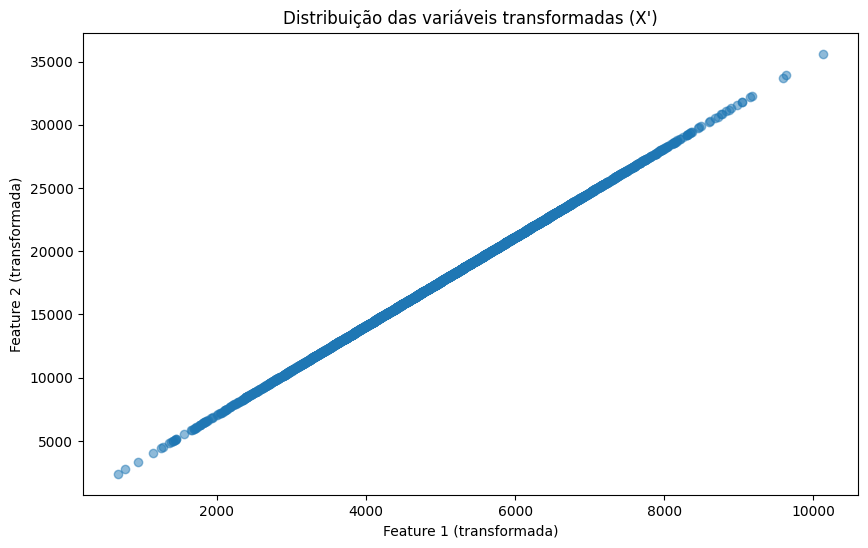

In [42]:
# Pra testar isso, resolvi plotar um gráfico e verificar algumas colunas

plt.figure(figsize=(10, 6))

plt.scatter(X_prime[:, 0], X_prime[:, 1], alpha=0.5)
plt.title('Distribuição das variáveis transformadas (X\')')
plt.xlabel('Feature 1 (transformada)')
plt.ylabel('Feature 2 (transformada)')
plt.show()

O gráfico mostra que ainda existe uma linearidade e uma correlação entre as duas features testadas, mas, sem saber do que se tratam, eu entendo que a proteção foi eficaz, porque eu não saberia dizer a que se referem esses dados.

Você pode recuperar os dados originais de $X′$ se souber $P$? Tente verificar isso com cálculos movendo $P$ do lado direito da fórmula acima para o esquerdo. As regras da multiplicação de matrizes são realmente úteis aqui

In [43]:
P_inv = np.linalg.inv(P)

# Recuperando X a partir de X' = X * P
X_recovered = X_prime.dot(P_inv)

# Verificando se os dados recuperados são iguais aos originais
recovered_same_as_original = np.allclose(X, X_recovered)

print(f"Os dados recuperados são iguais aos dados originais? {recovered_same_as_original}")

Os dados recuperados são iguais aos dados originais? True


Ótimo, esse valor true indica que podemos recuperar os dados originais se tivermos P. Dessa forma, nenhuma informação foi perdida no processo de ofuscar os dados! Proteger, mas sem destruir. Era isso que queríamos!

Imprima todos os três casos para alguns clientes- Os dados originais
- O transformado
- O invertido (recuperado)

In [44]:

print("Dados originais (X):")
print(X[:5])  # Mostrando as primeiras 5 linhas dos dados originais

print("\nDados transformados (X'):")
print(X_prime[:5])  # Mostrando as primeiras 5 linhas dos dados transformados

print("\nDados recuperados (X' * P^-1):")
print(X_recovered[:5])  # Mostrando as primeiras 5 linhas dos dados recuperados

Dados originais (X):
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]
 [1.00e+00 2.80e+01 2.61e+04 0.00e+00]]

Dados transformados (X'):
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]
 [ 3347.17673462 11782.82928336  9699.99894205 24211.27337753]]

Dados recuperados (X' * P^-1):
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 [-4.84498208e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04 -1.01990740e-13]]


Você provavelmente pode ver que alguns valores não são exatamente iguais aos dos dados originais. Qual pode ser a razão disso?

Isso é esperado e acontece por pequenos erros/diferenças no arredondamento dos cálculos. Porém, temos os dados recuperados com preisão suficiente. Essas diferenças são insignificantes!

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- O modelo de RL customizado foi implementado usando operações matriciais
- Os dados normalizados foram usados
- As métricas `REQM` e `R2` foram calculadas 
</div>

## Provas de que a ofuscação de dados pode funcionar com a Regressão Linear

A tarefa de regressão foi resolvida com regressão linear neste projeto. Sua próxima tarefa é provar analiticamente que o método de ofuscação fornecido não afetará a regressão linear em termos de valores preditos, ou seja, seus valores permanecerão os mesmos. Você acredita nisso? Bem, você não precisa acreditar, você deve provar isso!

Assim, os dados são ofuscados e há $X \ P$ em vez de apenas X agora. Consequentemente, existem outros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Como  $w$ e $w_P$ seriam ligados se você simplificasse a fórmula para $w_P$ acima? 

Quais seriam os valores previstos com $w_P$? 

O que isso significa para a qualidade da regressão linear se você medir com REQM?

Verifique o Apêndice B Propriedades das Matrizes no final do caderno. Existem fórmulas úteis lá!

Nenhum código é necessário nesta seção, apenas explicação analítica!

**Resposta**

Como w e wp seriam ligados se você simplificasse a fórmula para wp acima?

$$
\begin{align}
w_P &= [(XP)^T XP]^{-1} (XP)^T y \\
&= [X^TP^T XP]^{-1} (XP)^T y \\
&= [P (X^TP^T X)]^{-1} (XP)^T y \\
&= P^{-1} [X^TP^T X]^{-1} (XP)^T y \\
&= P^{-1} (P^T)^{-1} [X^T X]^{-1} (XP)^T y \\
&= P^{-1} (P^T)^{-1} [X^T X]^{-1} X^T P^T y \\
&= P^{-1} [X^T X]^{-1} X^T y
\end{align}
$$

Derivando a função acima temos que:
$$
\begin{align}
w_P &= P^{-1} w \\
w_P P &= P P^{-1} w \\
w_P P &= w
\end{align}
$$


Quais seriam os valores previstos com  𝑤𝑃?

$$
\hat{y} = X w \\
\hat{y} = X w_P P \\
$$

O que isso significa para a qualidade da regressão linear se você medir com REQM?

Com as fórmulas nas questões 1 e 2, mostramos que os dados previstos, comparados com a ofuscação e os dados originais, não se alteram. Isso é um indicativo claro de que o desempenho do modelo, que podemos medir com RMSE e R2, nãoi muda. Assim, esse ofuscamento não significa nada para as métricas. 

**Prova analítica**

### Prova Analítica

#### Passo 1: Encontrando os pesos \( w_P \) para os dados ofuscados

Começamos com a fórmula para calcular os pesos \( w \) na regressão linear usando os dados originais \( X \) e o vetor de objetivos \( y \):

$$
w = (X^T X)^{-1} X^T y
$$

Quando os dados são ofuscados por uma matriz invertível \( P \), os dados transformados são \( X' = X \times P \). Então, a fórmula para os pesos \( w_P \) dos dados ofuscados é:

$$
w_P = [(XP)^T (XP)]^{-1} (XP)^T y
$$

Usando as propriedades das transpostas de matrizes, podemos reescrever isso como:

$$
w_P = [P^T X^T X P]^{-1} P^T X^T y
$$

#### Passo 2: Simplificando a fórmula para \( w_P \)

Vamos simplificar a fórmula para \( w_P \) usando a propriedade da inversa de matrizes:

$$
(P^T A P)^{-1} = P^{-1} A^{-1} (P^T)^{-1}
$$

Aplicando isso à nossa fórmula:

$$
w_P = [P^T (X^T X) P]^{-1} P^T X^T y
$$
$$
w_P = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

Observando que \( (P^T)^{-1} P^T = I \), onde \( I \) é a matriz identidade, obtemos:

$$
w_P = P^{-1} (X^T X)^{-1} X^T y
$$

Portanto, podemos ver que:

$$
w_P = P^{-1} w
$$

#### Passo 3: Valores preditos com \( w_P \)

Os valores preditos \( \hat{y}_P \) usando os pesos \( w_P \) são dados por:

$$
\hat{y}_P = X P w_P
$$

Substituindo \( w_P \) pela expressão simplificada que encontramos:

$$
\hat{y}_P = X P (P^{-1} w)
$$
$$
\hat{y}_P = X (P P^{-1}) w
$$
$$
\hat{y}_P = X I w
$$
$$
\hat{y}_P = X w
$$

Portanto, os valores preditos com \( w_P \) são os mesmos que os valores preditos com \( w \):

$$
\hat{y}_P = \hat{y}
$$


## Teste de regressão linear com ofuscação de dados

Agora, vamos provar que a Regressão Linear pode funcionar computacionalmente com a transformação de ofuscação escolhida.
Crie um procedimento ou uma classe que execute a Regressão Linear opcionalmente com a ofuscação. Você pode usar uma implementação pronta de Regressão Linear do scikit-learn ou sua própria.

Execute a Regressão Linear para os dados originais e os ofuscados, compare os valores previstos e os valores da métrica $R^2$ do REQM. Há alguma diferença?

**Procedimento**

- Crie uma matriz quadrada $P$ de números aleatórios.
- Verifique se é invertível. Caso contrário, repita o primeiro ponto até obtermos uma matriz invertível.
- <! seu comentário aqui!>
- Use $XP$ como a nova matriz de características

In [45]:
# Criamos uma função que gera uma matriz e garante que ela seja inversível, com um while no final.
def generate_invertible_matrix(X):
    rng = np.random.default_rng(seed=42)
    P = rng.random(size=(X.shape[1], X.shape[1]))
    
    while np.linalg.det(P) == 0:
        P = rng.random(size=(X.shape[1], X.shape[1]))  # Gerar novamente se o determinante for 0
    return P

In [46]:
#função que ofusca os dados
def obfuscate_data(X, P):
    return X.dot(P)

In [47]:
#Criando função que treina e avalia as métricas pedidas para o modelo
def evaluate_regression(X_train, X_test, y_train, y_test, P=None):
    # Se P não for fornecido, use os dados originais
    if P is not None:
        X_train = obfuscate_data(X_train, P)
        X_test = obfuscate_data(X_test, P)
    
    # Treinando o modelo de regressão linear
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Previsões
    y_pred = model.predict(X_test)
    
    # Avaliando a qualidade do modelo
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return y_pred, rmse, r2

In [48]:
#Geramos a matriz e avaliamos com os dois tipos diferentes de dados
P = generate_invertible_matrix(X)

# Avaliar com dados originais
y_pred_orig, rmse_orig, r2_orig = evaluate_regression(X_train, X_test, y_train, y_test)

# Avaliar com dados ofuscados (usando a matriz P)
y_pred_obf, rmse_obf, r2_obf = evaluate_regression(X_train, X_test, y_train, y_test, P)

In [49]:
print("Resultados com dados originais:")
print(f"REQM (RMSE): {rmse_orig:.2f}")
print(f"R2: {r2_orig:.2f}")

print("\nResultados com dados ofuscados:")
print(f"REQM (RMSE): {rmse_obf:.2f}")
print(f"R2: {r2_obf:.2f}")

Resultados com dados originais:
REQM (RMSE): 0.34
R2: 0.43

Resultados com dados ofuscados:
REQM (RMSE): 0.34
R2: 0.43


Aqui, geramos as matrizes necessárias, treinamos o modelo e verificamos as métricas pedidas. Como esperado, os valores são iguais aos alcançados com a a primeira regressão linear. Além disso, eles não mudam no teste com os dados originais e com os dados ofuscados, o que era exatamente o que queríamos provar. Bom... agora, está provado!

# Conclusões

Finalizamos aqui mais um projeto do curso. primeiro, verificamos os dados e garantimos que eles estavam limpos e prontos para trabalhar. Nessa etapa, tudo o que fizemos foi trocar o tipo de dados de uma das colunas, mas todo o dataset estava em excelente estado.

N tarefa 1, nos foi pedido para encontrar clientes similares a um determinado tipo. Fizemos isso com uma função para encontrar vizinhos próximos. Testamos e percebemos diferenças importantes entre as distâncias euclidiana e Manhattan, como, por exemplo, o impacto que a escalonabilidade dos dados tem sobre a função, respondendo as perguntas da etapa.

Na tarefa 2, tentamos prever se o cliente receberia ou não pagamento do seguro. Como pedido na tarefa, verificamos que, com os dados escalados, um knn funcionou myuito melhor do que o modelo dummy. Atingimos f1 score de 0.97. Na tarefa 3, preparamos um modelo de regressão linear que atingiu valores razoáveis.

Por fim, realizamos a ofuscação dos dados. Garantimos que o desempenho da regressão linear não caísse devido à adição dessa camada de proteção 

# Checklist

Digite 'x' para verificar. Em seguida, pressione Shift + Enter.

- [x]  O Jupyter Notebook está aberto.
- [ x]  O código está livre de erros
- [ x]  As células são organizadas em ordem de lógica e execução
- [x ]  A tarefa 1 foi executada
    - [x ]  Existe o procedimento que pode retornar k clientes semelhantes a um determinado cliente
    - [x ]  O procedimento é testado para todas as quatro combinações propostas
    - [ x]  As perguntas sobre a escala/distâncias são respondidas
- [ x]  A tarefa 2 foi executada
    - [ x]  O modelo de classificação aleatória é construído e testado para todos os níveis de probabilidade
    - [x ]  O modelo de classificação kNN é construído e testado tanto para os dados originais quanto para os escalados, a métrica F1 é calculada. 
    - [x ]  A tarefa 3 foi executada
    - [ x]  A solução de regressão linear é implementada com operações matriciais.
    - [ x]  O REQM é calculado para a solução implementada.
- [ x]  A tarefa 4 foi executada
    - [ x]  Os dados são ofuscados com uma matriz P aleatória e invertível
    - [ x]  Os dados ofuscados são recuperados, alguns exemplos são impressos    - [x ]  A prova analítica de que a transformação não afeta o REQM é fornecida
    - [x ]  A prova computacional de que a transformação não afeta o REQM é fornecida- [x ]  As conclusões foram feitas

# Apêndices

## Apêndice A: Escrevendo Fórmulas em Notebooks Jupyter

Você pode escrever fórmulas em seu Jupyter Notebook em uma linguagem de marcação de texto fornecida por um sistema de publicação de alta qualidade chamado $\LaTeX$ (pronuncia-se "Lah-tech"), e elas se parecerão com fórmulas em livros didáticos.
Para colocar uma fórmula em um texto, coloque o cifrão ($) antes e depois do texto da fórmula, por exemplo $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Se uma fórmula deve estar em seu próprio parágrafo, coloque o cifrão duplo ($$) antes e depois do texto da fórmula, por exemplo

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

A linguagem de marcação do [LaTeX](https://en.wikipedia.org/wiki/LaTeX) é muito popular entre as pessoas que usam fórmulas em seus artigos, livros e textos. Pode ser complexo, mas o básico é fácil. Confira esta [folha de dicas](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) de duas páginas  para aprender a compor as fórmulas mais comuns.

## Apêndice B: Propriedades das Matrizes

Matrizes têm muitas propriedades em Álgebra Linear. Algumas delas estão listadas aqui, o que pode ajudar na prova analítica deste projeto.

<table>
<tr>
<td>Distributividade</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Não-comutatividade</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propriedade associativa da multiplicação</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propriedade de identidade multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversividade da transposição de um produto de matrizes,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>